In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy.ma as ma
import pandas as pd
import scipy.stats

In [2]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(project='UWAS0070',
                       memory='200G')
cluster.scale(36)

from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://128.117.181.227:42077 Dashboard: http://128.117.181.227:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
def is_month(month,index):
    return month==index

In [23]:
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [26]:
ds = xr.open_dataset('/glade/work/lettier/NUDGEsh/sic_processed_combined_sh_1979-2018_reg1deg.nc')

In [27]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 360, name: 40, time: 480)
Coordinates:
  * latitude   (latitude) float32 -30.5 -31.5 -32.5 -33.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
  * name       (name) object 'Bootstrap' 'NASA-Team' ... 'LENS-34' 'LENS-35'
Data variables:
    siconc     (name, time, latitude, longitude) float32 ...
    tarea      (latitude, longitude) float64 ...

In [28]:
ds = ds.chunk({'latitude': 30, 'longitude': 30}  )

In [29]:
monds = ds.sel(time=is_month(ds['time.month'],3)) # select March

In [30]:
outds = xr.apply_ufunc(new_linregress, np.arange(len(monds.time)), monds.siconc,
                       input_core_dims=[['time'], ['time']],
                       output_core_dims=[["stats"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       output_sizes={"stats": 5},
                      ) # stats = slope, intercept, pval etc

In [31]:
outds

<xarray.DataArray 'siconc' (name: 40, latitude: 60, longitude: 360, stats: 5)>
dask.array<vectorize_new_linregress, shape=(40, 60, 360, 5), dtype=float64, chunksize=(40, 30, 30, 5), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -30.5 -31.5 -32.5 -33.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * name       (name) object 'Bootstrap' 'NASA-Team' ... 'LENS-34' 'LENS-35'
Dimensions without coordinates: stats

In [32]:
outds.stats

<xarray.DataArray 'stats' (stats: 5)>
array([0, 1, 2, 3, 4])
Dimensions without coordinates: stats

In [33]:
outds['stats'] = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

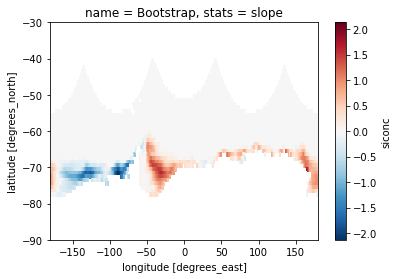

In [34]:
outds.isel(stats=0).isel(name=0).plot()